In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [2]:
from pathlib import Path
import argparse
import json
import os
import random
import signal
import sys
import time
import urllib

from torch import nn, optim
from torchvision import datasets, transforms
import torch
torch.cuda.empty_cache()

import resnet

import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json

import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

import resnet

import torchvision

from munkres import Munkres

import augmentations as aug

In [3]:
batch_size = 1

In [4]:
class SN7Dataset(Dataset):
    
    def __init__(self, transform=None, train=True):
        
        if train == True:
            self.img_ids_labels = pd.read_csv("../../ids_and_labels_train_repeated.csv", header = None) 
        else:
            self.img_ids_labels = pd.read_csv("../../ids_and_labels_val_repeated.csv", header = None)
            
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/train'
        self.transform = transform
        
    def __getitem__(self, idx):
        #print(self.img_ids_labels.iloc[idx, 0])
        image_id, patch_id = self.img_ids_labels.iloc[idx, 0].split("!")[1],self.img_ids_labels.iloc[idx, 0].split("!")[0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        
        image_padded = torch.nn.functional.pad(image, pad=(0, 1024 - image.shape[2], 0, 1024 - image.shape[1]))
        patches = image_padded.unfold(1, 256, 256).unfold(2, 256, 256)
        patches = patches.reshape(3, -1, 256, 256)
        patches = patches.permute(1,0,2,3)
        
        image = patches[int(patch_id)]
        
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 3])).type(torch.LongTensor)
        
        #patches = patches.view(-1, 3, 256, 256)
        #print(patches.shape)
        #label = label.flatten()
        #label = label.type(torch.LongTensor)
        
        
        image = self.transform(image)
                
            
        #if self.target_transform:
            #label = self.target_transform(label)
            
        
        return image, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

In [5]:
#transform = transforms.Compose([ transforms.Resize(224), torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

seen_transforms = transforms.Compose(
            [   
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                #transforms.Resize(224),
                normalize,
            ]
        )

#seen_transforms = aug.TrainTransform()

unseen_transforms = transforms.Compose(
            [
                transforms.CenterCrop(224),
                #transforms.Resize(224),
                normalize,
            ])

#unseen_transforms = seen_transforms
                
test_seen_dataset = SN7Dataset(train=True, transform = seen_transforms)
test_unseen_dataset = SN7Dataset(train=False, transform = unseen_transforms)

test_seen_loader = DataLoader(dataset=test_seen_dataset, batch_size = batch_size, shuffle = False)
test_unseen_loader = DataLoader(dataset=test_unseen_dataset, batch_size = batch_size, shuffle = False)

In [6]:
torch.cuda.current_device()
torch.cuda.set_device(0)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()
print(device)

(12268863488, 12806062080)
0


In [7]:
#JUST TRY LOADING MODEL LIKE THIS
#backbone, embedding = resnet.__dict__['resnet18'](zero_init_residual=True)
#backbone.load_state_dict(torch.load('exp/resnet18_2.pth'))
#backbone.to(device)
#backbone.eval()

In [8]:
backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
#state_dict = torch.load('exp/resnet18_100_newest.pth', map_location="cpu")
#state_dict = torch.load('exp/resnet50_100epochs_16_factor.pth', map_location="cpu")
#state_dict = torch.load('exp/vicreg_temporal_200.pth', map_location="cpu")
state_dict = torch.load('exp/resnet50_vicreg_sn7_temporal_100.pth')
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.to(device)

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [9]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [10]:
labels_list = []
embeddings_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_seen_loader):
        if i%500 == 0:
            print(i)
        #print(inputs[1].shape)
        embedding = backbone(inputs.to(device))
        embeddings_list.append(embedding)
        labels_list.append(labels)

    


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000


In [11]:
embeddings_seen_arr = np.zeros((len(test_seen_loader), 2048))
counter = 0
for embedding in embeddings_list:
    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

print(embeddings_seen_arr)
labels_seen_arr = np.zeros(len(test_seen_loader))
counter = 0
for i in labels_list:
    labels_seen_arr[counter] = i.detach().numpy()
    counter += 1
print(labels_seen_arr)

#np.savetxt("seen_embeddings.csv", embeddings_seen_arr, delimiter=",", fmt='%s')

[[0.02465937 0.01064961 0.01137067 ... 0.17349614 0.01076042 0.00472382]
 [0.0215885  0.08200649 0.         ... 0.17212871 0.00371528 0.01565442]
 [0.02478289 0.14344744 0.13246875 ... 0.17439838 0.03288446 0.01831415]
 ...
 [0.00764719 0.07747109 0.00837685 ... 0.17782748 0.04598457 0.0184386 ]
 [0.         0.26084465 0.         ... 0.17377204 0.00381584 0.02669172]
 [0.         0.40794745 0.16590698 ... 0.25681105 0.00055405 0.01111012]]
[18. 11.  5. ... 27. 29. 29.]


In [12]:
labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_unseen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone(inputs.to(device))
        embeddings_unseen_list.append(embedding)
        labels_unseen_list.append(labels)
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [13]:
embeddings_unseen_arr = np.zeros((len(test_unseen_loader), 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

In [14]:
print(embeddings_unseen_arr)
labels_unseen_arr = np.zeros(len(test_unseen_loader))
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter] = i.detach().numpy()
    counter += 1
print(labels_unseen_arr)

#np.savetxt("unseen_embeddings.csv", embeddings_unseen_arr, delimiter=",", fmt='%s')
    

[[0.00000000e+00 9.49207414e-03 0.00000000e+00 ... 1.79268658e-01
  0.00000000e+00 1.83629356e-02]
 [2.44265720e-02 8.15552846e-03 1.55464010e-02 ... 1.75237805e-01
  0.00000000e+00 3.38147849e-01]
 [8.92966315e-02 1.23539623e-02 0.00000000e+00 ... 1.75425544e-01
  0.00000000e+00 2.81941652e-01]
 ...
 [6.16500247e-03 1.74901351e-01 3.65631171e-02 ... 1.73824236e-01
  0.00000000e+00 2.89744069e-03]
 [0.00000000e+00 7.52054760e-03 1.18713593e-04 ... 1.76334575e-01
  7.19317002e-04 9.89743993e-02]
 [1.31263328e-03 1.99106991e-01 1.49921542e-02 ... 3.41056198e-01
  5.23403697e-02 3.30884242e-03]]
[ 7. 29. 18. ... 29. 29.  8.]


In [15]:
for i in range(embeddings_seen_arr.shape[0]):
    if len(np.unique(embeddings_seen_arr[i,:]))==1:
        print('yes')
for i in range(embeddings_unseen_arr.shape[0]):
    if len(np.unique(embeddings_unseen_arr[i,:]))==1:
        print('yes_unseen')

[ 0.  1.  2.  3.  4.  5.  6.  7. 10. 14. 15. 16. 17. 18. 19. 20. 22. 23.
 24. 25. 26. 27. 28. 29.]


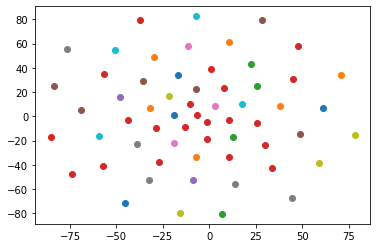

In [16]:
#JUST TRY DELETE LATER

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_unseen_arr_trial = embeddings_unseen_arr[60:120,:]
labels_unseen_arr_trial = labels_unseen_arr[60:120]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

u_labels = np.unique(labels_unseen_arr_trial)
print(u_labels)

embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

for i in u_labels:
    
    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
plt.show()

In [17]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50,200]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy: 0.9962976022566996
Accuracy: 0.9961212976022567
Accuracy: 0.9962976022566996
Accuracy: 0.9962976022566996
Accuracy: 0.9952397743300423
Accuracy: 0.9866008462623413
Accuracy: 0.9608603667136812
Accuracy: 0.9178420310296191
Accuracy: 0.46632581100141046


In [18]:
def get_y_preds(cluster_assignments, y_true, n_clusters):
    '''
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)

    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset

    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred, confusion_matrix 

def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))

    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:,j]) # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i,j]
            cost_matrix[j,i] = s-t
    return cost_matrix

def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    clusterLabels = np.zeros(n_clusters)
    for i in range(n_clusters):
        clusterLabels[i] = indices[i][1]
    return clusterLabels

In [19]:
from sklearn.cluster import AgglomerativeClustering

#labels_predicted = AgglomerativeClustering(n_clusters = 20).fit_predict(embeddings_unseen_arr)

#truth = labels_unseen_arr
#pred = labels_predicted
#print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

#print(sklearn.metrics.rand_score(labels_unseen_arr, labels_predicted))

whole_test_set = np.concatenate((embeddings_seen_arr,embeddings_unseen_arr), axis=0)
whole_labels = np.concatenate((labels_seen_arr, labels_unseen_arr))

labels_predicted = AgglomerativeClustering(n_clusters = 31).fit_predict(whole_test_set)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 31)[0] == truth )/len(truth) )

from sklearn.cluster import KMeans

#kmeans = KMeans(n_clusters=20, random_state=36).fit(embeddings_seen_arr)
#labels_predicted = kmeans.predict(embeddings_unseen_arr)
#print(labels_predicted.shape)

#truth = labels_unseen_arr
#pred = labels_predicted
#print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

kmeans = KMeans(n_clusters=31, random_state=36).fit(whole_test_set)
labels_predicted = kmeans.predict(whole_test_set)
print(whole_labels.shape)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 31)[0] == truth )/len(truth) )



Accuracy Afteer Hungarian Assignment: 0.19424365303244007
(22688,)
Accuracy Afteer Hungarian Assignment: 0.15968794076163612


In [21]:
#normalize = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
seen_transforms = transforms.Compose(
            [   
                #transforms.RandomResizedCrop(224),
                #transforms.RandomHorizontalFlip(),
                transforms.Resize(224),
                normalize,
            ]
        )

unseen_transforms = transforms.Compose(
            [
                transforms.CenterCrop(224),
                #transforms.Resize(224),
                normalize,
            ])

test_seen_dataset = SN7Dataset(train=True, transform = seen_transforms)
test_unseen_dataset = SN7Dataset(train=False, transform = unseen_transforms)

test_seen_loader = DataLoader(dataset=test_seen_dataset, batch_size = batch_size, shuffle = False)
test_unseen_loader = DataLoader(dataset=test_unseen_dataset, batch_size = batch_size, shuffle = False)

In [22]:
#####FOR SUPERVİSED MODEL!!!!

backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
#state_dict = torch.load('../../Supervised_Model.pth', map_location="cpu")
state_dict = torch.load('../../Supervised_Model_Resnet50_Scheduler_3.pth', map_location="cpu")
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.to(device)

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [23]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [24]:
labels_list = []
embeddings_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_seen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone(inputs.to(device))
        embeddings_list.append(embedding)
        labels_list.append(labels)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000


In [25]:
embeddings_seen_arr = np.zeros((len(test_seen_loader), 2048))
counter = 0
for embedding in embeddings_list:
    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

print(embeddings_seen_arr)
labels_seen_arr = np.zeros(len(test_seen_loader))
counter = 0
for i in labels_list:
    labels_seen_arr[counter] = i.detach().numpy()
    counter += 1
print(labels_seen_arr)

[[0.81858546 1.11875343 1.12111044 ... 0.68497401 1.21348774 1.52422202]
 [0.51768261 1.01442158 1.53919291 ... 1.03923965 1.74519217 0.84151483]
 [0.8443886  0.62078846 1.67340183 ... 0.27254659 0.68678749 1.16173959]
 ...
 [0.74392712 0.25871077 0.9635517  ... 0.99214137 0.69227654 0.67700303]
 [0.93434405 0.9419772  1.08061421 ... 1.76264203 0.42396316 0.46477273]
 [1.10899627 1.40967703 1.08249307 ... 1.28508031 0.80823416 0.68670404]]
[18. 11.  5. ... 27. 29. 29.]


In [26]:
labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_unseen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone(inputs.to(device))
        embeddings_unseen_list.append(embedding)
        labels_unseen_list.append(labels)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [27]:
embeddings_unseen_arr = np.zeros((len(test_unseen_loader), 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

print(embeddings_unseen_arr)
labels_unseen_arr = np.zeros(len(test_unseen_loader))
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter] = i.detach().numpy()
    counter += 1
print(labels_unseen_arr)

[[0.61229819 0.23138921 1.24909306 ... 0.47410858 1.51899529 7.69545126]
 [1.7045126  2.46230197 1.36824906 ... 0.68633831 0.95245135 0.09715678]
 [1.33213508 1.33554041 0.32033682 ... 0.27531877 0.0671477  0.84265602]
 ...
 [1.06390369 0.82959312 1.03194094 ... 1.18938518 1.41326511 0.31899664]
 [1.31412113 1.96323121 1.45331585 ... 0.76647615 1.28277433 0.10620394]
 [0.63542736 0.85212439 0.97002625 ... 2.40373659 0.75511533 0.99090129]]
[ 7. 29. 18. ... 29. 29.  8.]


[ 0.  1.  2.  5.  6.  7.  9. 10. 13. 14. 15. 16. 17. 18. 22. 23. 25. 26.
 27. 29.]


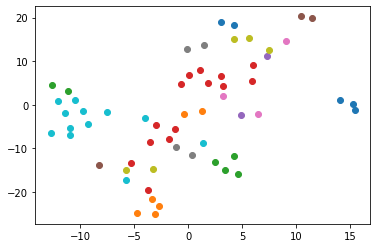

In [28]:
#JUST TRY DELETE LATER

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_unseen_arr_trial = embeddings_unseen_arr[0:60,:]
labels_unseen_arr_trial = labels_unseen_arr[0:60]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

u_labels = np.unique(labels_unseen_arr_trial)
print(u_labels)

embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

for i in u_labels:
    
    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
plt.show()

In [29]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50, 200]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy: 0.8494358251057827
Accuracy: 0.8608956276445698
Accuracy: 0.8718265162200282
Accuracy: 0.8746473906911142
Accuracy: 0.8720028208744711
Accuracy: 0.859308885754584
Accuracy: 0.8543723554301833
Accuracy: 0.8506699576868829
Accuracy: 0.8007757404795487


In [30]:
from sklearn.cluster import AgglomerativeClustering

#labels_predicted = AgglomerativeClustering(n_clusters = 20).fit_predict(embeddings_unseen_arr)

#truth = labels_unseen_arr
#pred = labels_predicted
#print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

#print(sklearn.metrics.rand_score(labels_unseen_arr, labels_predicted))

whole_test_set = np.concatenate((embeddings_seen_arr,embeddings_unseen_arr), axis=0)
whole_labels = np.concatenate((labels_seen_arr, labels_unseen_arr))

labels_predicted = AgglomerativeClustering(n_clusters = 31).fit_predict(whole_test_set)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 31)[0] == truth )/len(truth) )

from sklearn.cluster import KMeans

#kmeans = KMeans(n_clusters=20, random_state=36).fit(embeddings_seen_arr)
#labels_predicted = kmeans.predict(embeddings_unseen_arr)
#print(labels_predicted.shape)

#truth = labels_unseen_arr
#pred = labels_predicted
#print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

kmeans = KMeans(n_clusters=31, random_state=36).fit(whole_test_set)
labels_predicted = kmeans.predict(whole_test_set)
print(whole_labels.shape)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 31)[0] == truth )/len(truth) )

Accuracy Afteer Hungarian Assignment: 0.502027503526093
(22688,)
Accuracy Afteer Hungarian Assignment: 0.4677362482369535


In [34]:
from sklearn.cluster import AgglomerativeClustering

labels_predicted = AgglomerativeClustering(n_clusters = 31).fit_predict(embeddings_unseen_arr)

truth = labels_unseen_arr
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 31)[0] == truth )/len(truth) )

print(sklearn.metrics.rand_score(labels_unseen_arr, labels_predicted))

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=31, random_state=36).fit(embeddings_seen_arr)
labels_predicted = kmeans.predict(embeddings_unseen_arr)
print(labels_predicted.shape)

truth = labels_unseen_arr
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 31)[0] == truth )/len(truth) )

from sklearn import metrics

print(metrics.rand_score(labels_unseen_arr, labels_predicted))

Accuracy Afteer Hungarian Assignment: 0.5599435825105783
0.9169372844146313
(5672,)
Accuracy Afteer Hungarian Assignment: 0.53737658674189
0.9148088199706571


In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=31, random_state=36).fit(embeddings_seen_arr)
labels_predicted = kmeans.predict(embeddings_unseen_arr)
print(labels_predicted)

from sklearn import metrics

print(metrics.rand_score(labels_unseen_arr, labels_predicted))

[ 0 22 27 ...  1 22 25]
0.9148088199706571


In [63]:
print(embeddings_seen_arr.shape)
print(embeddings_unseen_arr.shape)

(17024, 512)
(5664, 512)
